In [1]:
import os
import sys
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np
import pyproj
from pyproj import CRS

import warnings
warnings.filterwarnings("ignore")

try:
    if 'conda' in sys.executable or 'miniconda' in sys.executable:
        env_path = os.path.dirname(os.path.dirname(sys.executable))
        proj_path = os.path.join(env_path, 'lib', 'python3.10', 'site-packages', 'pyproj', 'proj_dir', 'share', 'proj')
        if os.path.exists(proj_path):
            os.environ['PROJ_LIB'] = proj_path
        else:
            alt_path = os.path.join(env_path, 'share', 'proj')
            if os.path.exists(alt_path):
                os.environ['PROJ_LIB'] = alt_path
    proj_data_dir = pyproj.datadir.get_data_dir()
    if proj_data_dir and os.path.exists(proj_data_dir):
        os.environ['PROJ_LIB'] = proj_data_dir
except Exception:
    pass


/Users/shihao/miniconda3/envs/obspy/lib/python3.10/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


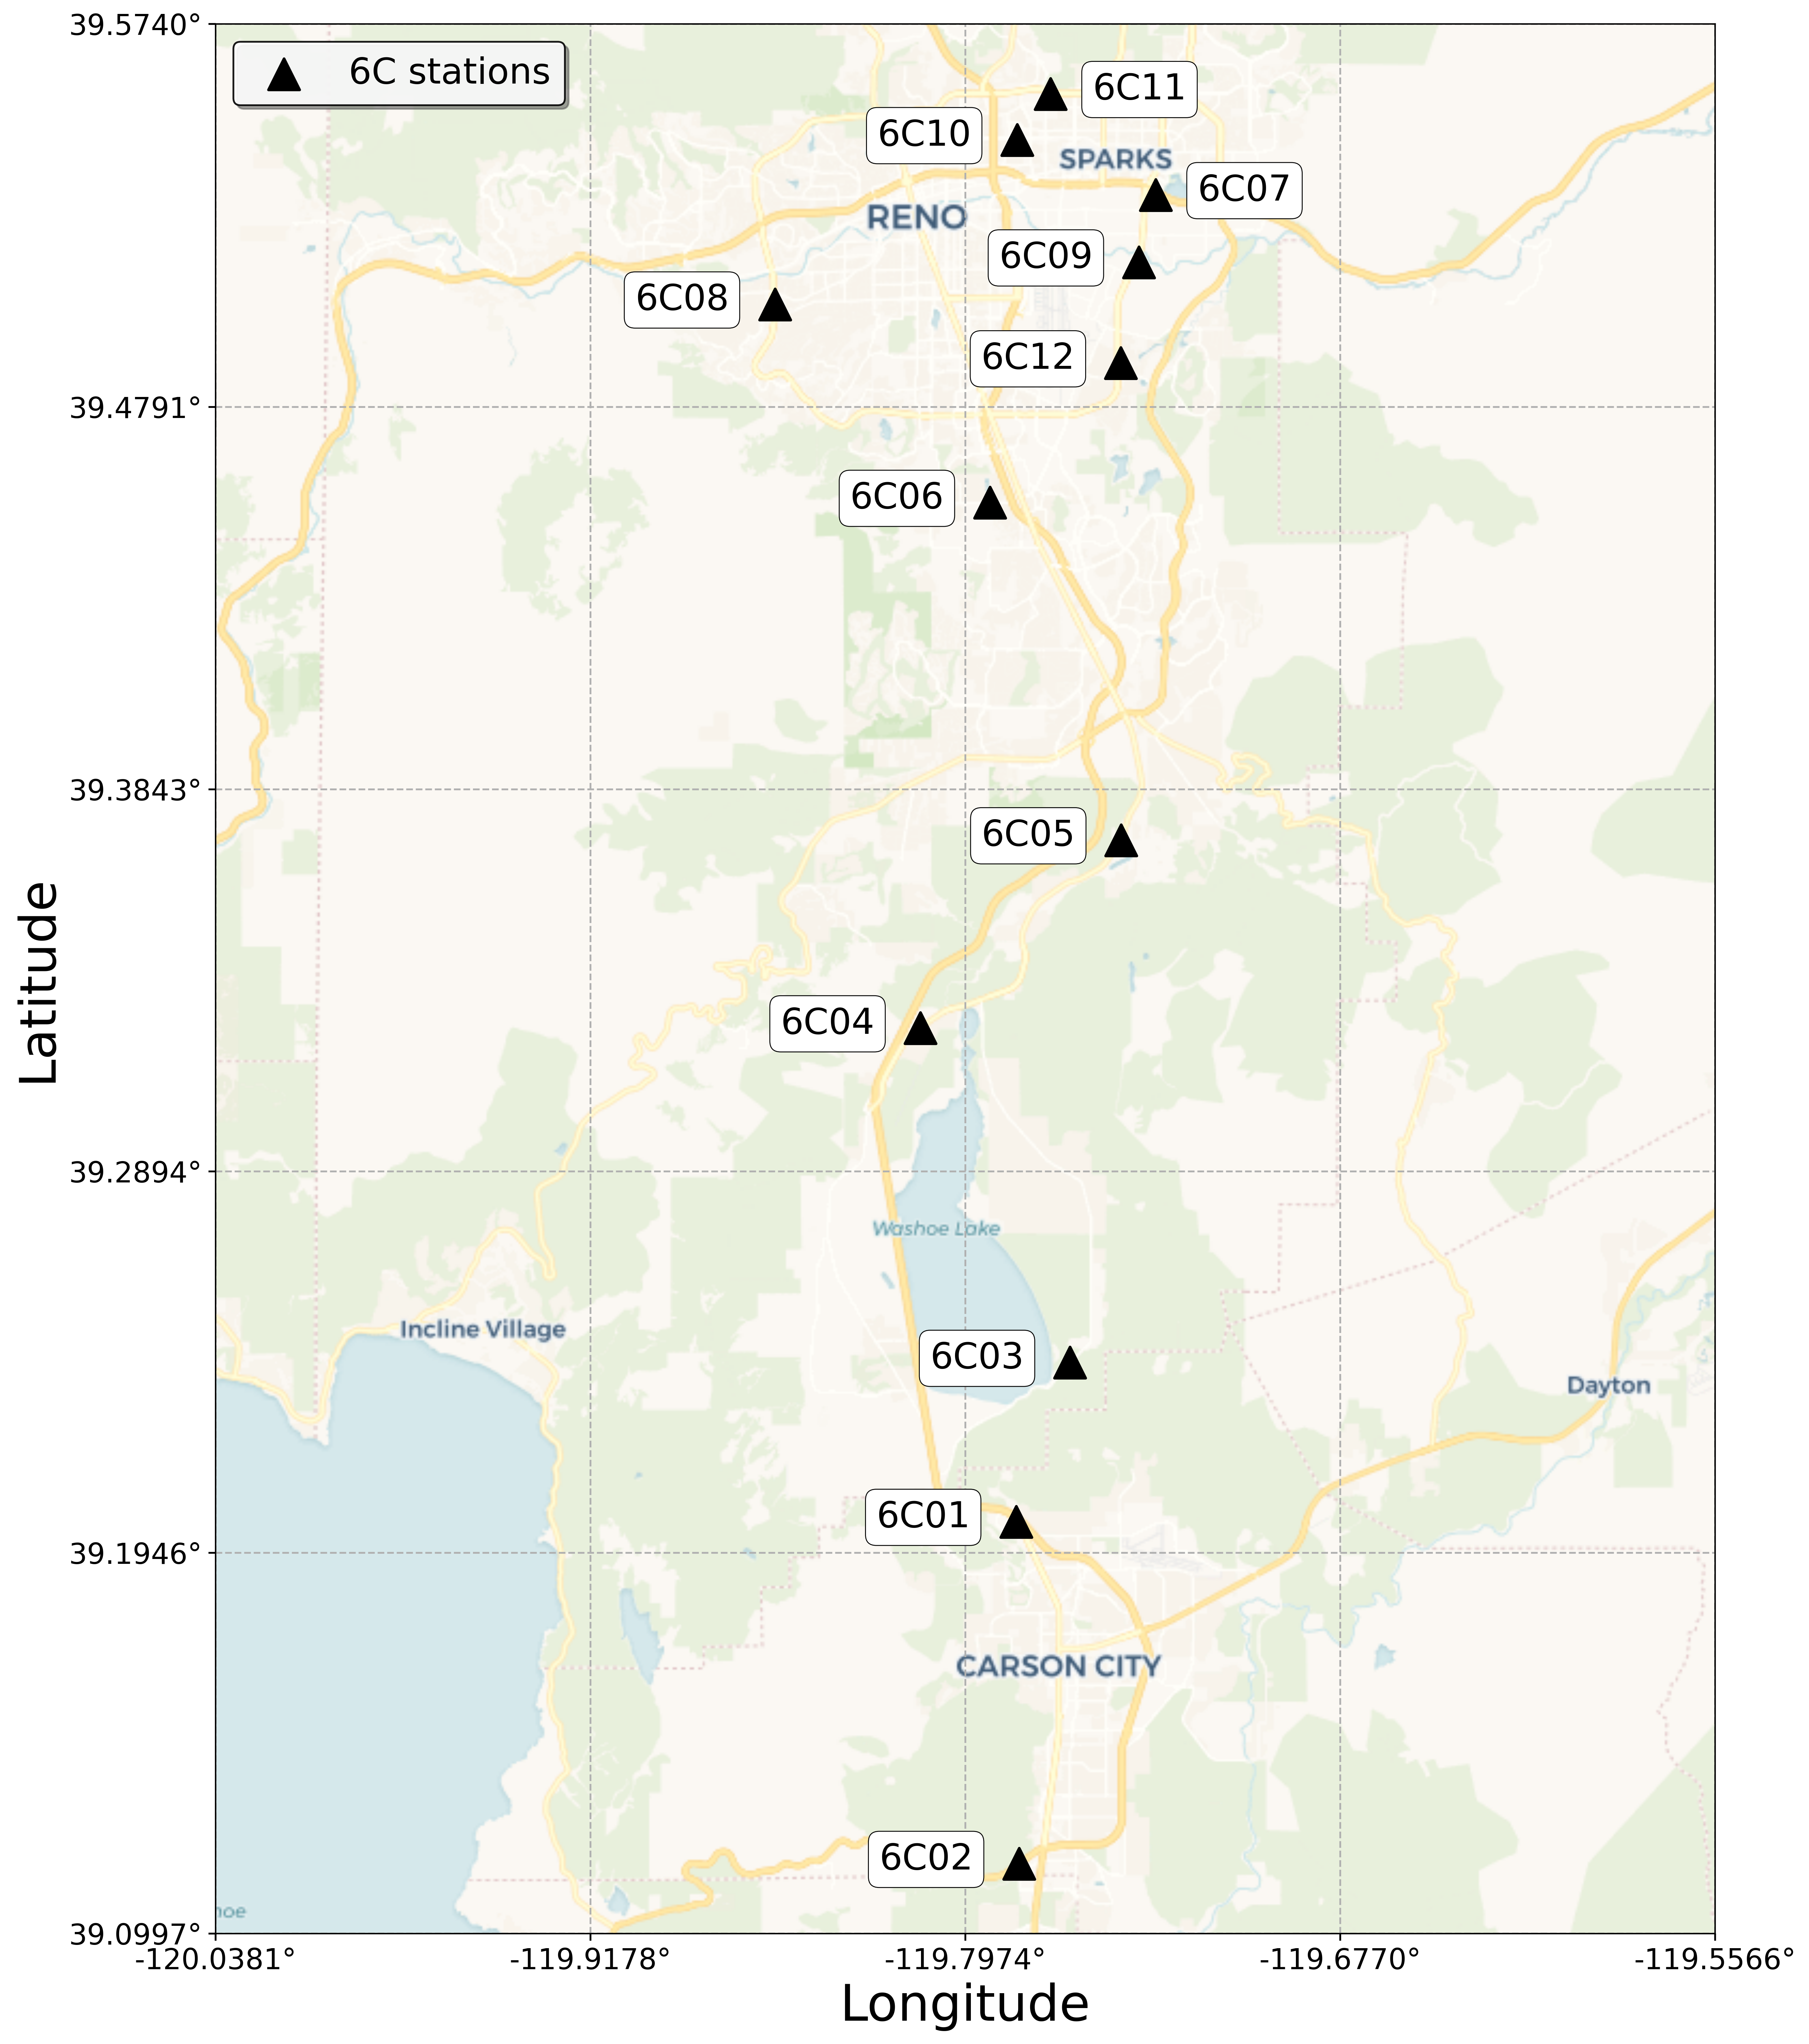

Station Coordinates (Decimal Degrees):
Station		Latitude	Longitude
---------------------------------------------
6C01		39.202303	-119.781017
6C02		39.117135	-119.780085
6C03		39.241860	-119.763730
6C04		39.325000	-119.811740
6C05		39.371688	-119.747272
6C06		39.455403	-119.789457
6C07		39.531647	-119.736227
6C08		39.504558	-119.858485
6C09		39.514982	-119.741617
6C10		39.545268	-119.780697
6C11		39.556687	-119.769942
6C12		39.489983	-119.747383


In [ ]:
# Station data
station_name = ['6C01','6C02','6C03','6C04','6C05','6C06',
                '6C07','6C08','6C09','6C10','6C11','6C12']

station_latitude_deg =  [39., 39., 39., 39., 39., 39.,
                         39., 39., 39., 39., 39., 39.]

station_latitude_min = [12.1382, 7.0281, 14.5116, 19.5000,
                        22.3013, 27.3242, 31.8988, 30.2735,
                        30.8989, 32.7161, 33.4012, 29.3990]

station_longitude_deg = [-119., -119., -119., -119., -119., -119.,
                         -119., -119., -119., -119., -119., -119.]

station_longitude_min = [46.8610, 46.8051, 45.8238, 48.7044,
                         44.8363, 47.3674, 44.1736, 51.5091,
                         44.4970, 46.8418, 46.1965, 44.843]

# Convert to decimal degrees
station_lat = [
    deg + minutes/60.0
    for deg, minutes in zip(station_latitude_deg, station_latitude_min)
]

station_lon = [
    - (abs(deg) + minutes/60.0)
    for deg, minutes in zip(station_longitude_deg, station_longitude_min)
]

df = pd.DataFrame({
    "name": station_name,
    "lat": station_lat,
    "lon": station_lon,
})


try:
    wgs84_crs = CRS.from_epsg(4326)
    web_mercator_crs = CRS.from_epsg(3857)
except Exception:
    wgs84_crs = CRS.from_string("+proj=longlat +datum=WGS84 +no_defs")
    web_mercator_crs = CRS.from_string("+proj=merc +a=6378137 +b=6378137 +lat_ts=0.0 +lon_0=0.0 +x_0=0.0 +y_0=0 +k=1.0 +units=m +nadgrids=@null +wktext +no_defs")

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["lon"], df["lat"]), crs=wgs84_crs)
gdf_3857 = gdf.to_crs(web_mercator_crs)

# Create coordinate transformers
try:
    transformer = pyproj.Transformer.from_crs(wgs84_crs, web_mercator_crs, always_xy=True)
    transformer_back = pyproj.Transformer.from_crs(web_mercator_crs, wgs84_crs, always_xy=True)
except Exception:
    transformer = pyproj.Transformer.from_crs(
        "+proj=longlat +datum=WGS84 +no_defs",
        "+proj=merc +a=6378137 +b=6378137 +lat_ts=0.0 +lon_0=0.0 +x_0=0.0 +y_0=0 +k=1.0 +units=m +nadgrids=@null +wktext +no_defs",
        always_xy=True
    )
    transformer_back = pyproj.Transformer.from_crs(
        "+proj=merc +a=6378137 +b=6378137 +lat_ts=0.0 +lon_0=0.0 +x_0=0.0 +y_0=0 +k=1.0 +units=m +nadgrids=@null +wktext +no_defs",
        "+proj=longlat +datum=WGS84 +no_defs",
        always_xy=True
    )

xmin, ymin, xmax, ymax = gdf_3857.total_bounds
lon_buffer = 20_000  # meters 
lat_buffer = 5_000   # meters 

x0 = xmin - lon_buffer
x1 = xmax + lon_buffer
y0 = ymin - lat_buffer/2
y1 = ymax + lat_buffer/2

base_width = 14
data_aspect = (y1 - y0) / (x1 - x0)
base_height = base_width * data_aspect

fig, ax = plt.subplots(figsize=(base_width, base_height), dpi=400)

ax.set_xlim(x0, x1)
ax.set_ylim(y0, y1)

gdf_3857.plot(ax=ax, markersize=300, color="black", marker='^', 
               linewidth=1.5, zorder=3, label='6C stations')

for x, y, name in zip(gdf_3857.geometry.x, gdf_3857.geometry.y, gdf_3857["name"]):
    if name == '6C07' or name == '6C11':
        ax.text(x + 1500, y-200, name, fontsize=20, zorder=4,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='black', linewidth=0.5))
    else:
        ax.text(x - 5000, y-200, name, fontsize=20, zorder=4,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white',
                         edgecolor='black', linewidth=0.5))

basemap_zoom = 11

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager, 
                crs=gdf_3857.crs.to_string(), zoom=basemap_zoom, zorder=1, attribution='')

lon_min, lat_min = transformer_back.transform(x0, y0)
lon_max, lat_max = transformer_back.transform(x1, y1)

lon_ticks_deg = np.linspace(lon_min, lon_max, 5)
lon_ticks_merc = [transformer.transform(lon, (lat_min + lat_max) / 2)[0] for lon in lon_ticks_deg]

lat_ticks_deg = np.linspace(lat_min, lat_max, 6)
lat_ticks_merc = [transformer.transform((lon_min + lon_max) / 2, lat)[1] for lat in lat_ticks_deg]

ax.set_xticks(lon_ticks_merc)
ax.set_xticklabels([f'{lon:.4f}°' for lon in lon_ticks_deg], fontsize=16)
ax.set_xlabel('Longitude', fontsize=28)

ax.set_yticks(lat_ticks_merc)
ax.set_yticklabels([f'{lat:.4f}°' for lat in lat_ticks_deg], fontsize=16)
ax.set_ylabel('Latitude', fontsize=28)

ax.tick_params(axis='both', which='major', length=4, width=1)
ax.grid(True, linestyle='--', linewidth=1)
ax.legend(loc='upper left', fontsize=20, framealpha=0.9, 
          fancybox=True, shadow=True, edgecolor='black', frameon=True)

plt.tight_layout()
plt.show()

# Print station coordinates
print("Station\t\tLatitude\tLongitude")
print("-" * 45)
for name, lat, lon in zip(station_name, station_lat, station_lon):
    print(f"{name}\t\t{lat:.6f}\t{lon:.6f}")
